In [1]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torchaudio

import sys
import os
from os.path import join as opj
from os.path import join, exists, split
from data.audioLDM_pre import *

import time
import urllib.request
import warnings
from tqdm import tqdm
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')

# from glmsingle.glmsingle import GLM_single
import pandas as pd
from nilearn import maskers
from nilearn import plotting
import tqdm

from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import matplotlib.pyplot as plt
import nilearn
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_contrast_matrix

default_n_threads = 64
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"


In [2]:
base_data_path="/data01/data/fMRI_music_genre/ds003720-download/derivatives"  # -download
base_event_path="/data01/data/fMRI_music_genre/ds003720-download"

subj="sub-001"

data_path=opj(base_data_path,subj,"func")
# event_path=opj(base_data_path,"events")

stim_dir="/data01/data/fMRI_music_genre/data_wav/genres_original"


sessions=os.listdir(data_path)

# training_stimuli= pd.read_csv(opj(base_data_path,"stimulus_ImageNetTraining.tsv"),sep="\t",names=["stimulus_id","category","label","idx"],header=None,dtype={"stimulus_id":str,"category":str,"label":int,"idx":int})
# test_stimuli= pd.read_csv(opj(base_data_path,"stimulus_ImageNetTest.tsv"),sep="\t",names=["stimulus_id","category","label","idx"],header=None,dtype={"stimulus_id":str,"category":str,"label":int,"idx":int})

In [3]:
filenames=glob.glob(opj(data_path,"*-preproc_bold.nii.gz"))

In [4]:
data=[]
events=[]
drop_first=0



for fn in tqdm.tqdm(filenames):
    #load file
    print(data_path,fn)
    
    name=fn.split("/")[-1].replace("_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz","_events.tsv")
    
    events_path=opj(base_event_path,subj,"func",name)
    # print(opj(data_path_ses,fn),opj(event_path,fn.replace('_bold_preproc.nii.gz','_events.tsv')))

    x=nib.load(fn)
    # df=pd.read_csv(fn.replace('_bold.nii','_events.tsv'),sep='\t',)
    df=pd.read_csv(events_path,sep='\t',)
    
    events.append(df)
    data.append(x)

100%|██████████| 18/18 [00:00<00:00, 411.27it/s]

/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720-

In [5]:
masker = maskers.NiftiMasker(mask_strategy="epi")
masker.fit(data[0])
report = masker.generate_report()



In [6]:
mask=False
tgt_dir=f"/data01/data/fMRI_music_genre/fmri_preproc_data/{subj}"

if mask:
    for i in tqdm.trange(len(data)):
        data[i]=masker.transform_single_imgs(data[i]).T
    
    os.makedirs(tgt_dir,exist_ok=True)

    for i in range(len(data)):
        print(data[i].shape)
        print(f"{tgt_dir}/{filenames[i].split('/')[-1].replace('.nii.gz','.npy')}")
        np.save(f"{tgt_dir}/{filenames[i].split('/')[-1].replace('.nii.gz','.npy')}",data[i])
else:
    for i,f in enumerate(filenames):
        data[i]=np.load(f"{tgt_dir}/{f.split('/')[-1].replace('.nii.gz','.npy')}")

In [7]:
len(data)

18

In [8]:
data[1].shape

(237653, 410)

In [9]:
for e in events:
    # e["category"]=e["genre"]+e["track"]
    e['category'] = e.apply(lambda row: f"{row['genre']}_{row['track']}", axis=1)    
    e["trial_type"]=e["category"]


In [10]:
TR=1.5
cleaned_data=[nilearn.signal.clean(d.T,detrend=True,standardize=True,t_r=TR) for d in data] # detrend and standardize
# nii_cleaned_data=[masker.inverse_transform(i) for i in cleaned_data]


In [11]:
cleaned_data[1].shape

(410, 237653)

## Prepare dataset

1) Save fMRI activity of each stim and related audio for all runs
2) Encode all audio
3) Clustering
4) Average fMRI activity
5) Can we predict music cluster from fMRI?

In [12]:
train_fmri=[]
test_fmri=[]
train_audio=[]
test_audio=[]
train_sr=[]
test_sr=[]

train_filename=[]
test_filename=[]

train_genre=[]
test_genre=[]

TR=1.5
stimdur=10
how_many_fmri_vols=10
fmri_vol_delay=3

for run_data, run_event, fn in zip(cleaned_data, events, filenames):
    print(fn)
    
    for i in tqdm.trange(len(run_event)):
        start_vol=(run_event.iloc[i].onset//TR).astype(np.int64) + fmri_vol_delay

        tmp_fmri_data=run_data[start_vol:start_vol+how_many_fmri_vols]
        tmp_stim=opj(stim_dir,run_event.iloc[i].genre.replace("'",""),run_event.iloc[i].genre.replace("'","")+"."+f"{run_event.iloc[i].track}".zfill(5)+".wav")
        audio,sr=torchaudio.load(tmp_stim)
        
        if "task-Test" in fn:
            test_fmri.append(tmp_fmri_data)
            test_audio.append(audio)
            test_sr.append(sr)
            test_genre.append(run_event.iloc[i].genre.replace("'",""))
            test_filename.append(run_event.iloc[i].genre.replace("'","")+"."+f"{run_event.iloc[i].track}".zfill(5))

        elif "task-Training" in fn:
            train_fmri.append(tmp_fmri_data)
            train_audio.append(audio)
            train_sr.append(sr)
            train_genre.append(run_event.iloc[i].genre.replace("'",""))
            train_filename.append(run_event.iloc[i].genre.replace("'","")+"."+f"{run_event.iloc[i].track}".zfill(5))
    
# train_fmri=torch.tensor(np.stack(train_fmri,0))
# test_fmri=torch.tensor(np.stack(test_fmri,0))

train_fmri_avg=[]
test_fmri_avg=[]
for f in tqdm.tqdm(train_fmri):
    train_fmri_avg.append(f.mean(0))
for f in tqdm.tqdm(test_fmri):
    test_fmri_avg.append(f.mean(0))
train_fmri_avg=torch.tensor(train_fmri_avg)
test_fmri_avg=torch.tensor(test_fmri_avg)






/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 85.30it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 86.23it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 89.83it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 91.21it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 87.95it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 89.08it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 91.75it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 92.62it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 91.90it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 90.27it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 91.15it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 90.79it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 91.34it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-10_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 91.77it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-11_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 89.80it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-12_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 90.84it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 41/41 [00:00<00:00, 92.64it/s]


/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Training_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


100%|██████████| 246/246 [00:00<00:00, 1230.10it/s]


In [13]:
train_genre=np.array(train_genre)
test_genre=np.array(test_genre)


In [14]:
print(train_fmri[0].shape)
print(test_fmri[0].shape)
print(train_audio[0].shape)
print(test_audio[0].shape)
print(train_sr[0])
print(train_genre.shape)
print(test_genre.shape)

(10, 237653)
(10, 237653)
torch.Size([1, 661504])
torch.Size([1, 661504])
22050
(492,)
(246,)


In [15]:
from transformers import AutoFeatureExtractor, ClapModel, ClapProcessor

model = ClapModel.from_pretrained("laion/larger_clap_music_and_speech").to("cuda:1")
processor = ClapProcessor.from_pretrained("laion/larger_clap_music_and_speech")

# model = ClapModel.from_pretrained("laion/clap-htsat-unfused").to("cuda:1")
feature_extractor = AutoFeatureExtractor.from_pretrained("laion/clap-htsat-unfused")


In [16]:
train_audio_feat=[]
test_audio_feat=[]

resampler = torchaudio.transforms.Resample(orig_freq=22050, new_freq=48000)

with torch.no_grad():
    for wv,sr in tqdm.tqdm(zip(train_audio,train_sr)):
        wv = resampler(wv)
        inputs = processor(audios=wv.squeeze(), return_tensors="pt", sampling_rate=48_000)
        audio_features = model.get_audio_features(inputs.input_features.to("cuda:1")).cpu()
        train_audio_feat.append(audio_features)

492it [03:07,  2.63it/s]


In [17]:
with torch.no_grad():
    for wv,sr in tqdm.tqdm(zip(test_audio,train_sr)):
        wv = resampler(wv)
        inputs = processor(audios=wv.squeeze(), return_tensors="pt", sampling_rate=48_000)
        audio_features = model.get_audio_features(inputs.input_features.to("cuda:1")).cpu()
        test_audio_feat.append(audio_features)

246it [01:31,  2.68it/s]


In [155]:
# train_audio_feat=[]
# test_audio_feat=[]

# with torch.no_grad():
#     for wv,sr in tqdm.tqdm(zip(train_audio,train_sr)):
#         inputs = feature_extractor(wv.squeeze(), return_tensors="pt",sampling_rate=48_000)
#         audio_features = model.get_audio_features(inputs.input_features.to("cuda:1")).cpu()
#         train_audio_feat.append(audio_features)

# with torch.no_grad():
#     for wv,sr in tqdm.tqdm(zip(test_audio,train_sr)):
#         inputs = feature_extractor(wv.squeeze(), return_tensors="pt",sampling_rate=48_000)
#         audio_features = model.get_audio_features(inputs.input_features.to("cuda:1")).cpu()
#         test_audio_feat.append(audio_features)



    
    

In [18]:
print(train_audio_feat[0].shape)
print(test_audio_feat[0].shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [19]:
train_audio_feat=torch.stack(train_audio_feat).squeeze()
test_audio_feat=torch.stack(test_audio_feat).squeeze()


In [20]:
print(train_audio_feat.shape)
print(test_audio_feat.shape)

torch.Size([492, 512])
torch.Size([246, 512])


In [21]:
from sklearn.cluster import KMeans

# Choose the number of clusters
n_clusters = 10  # Example, adjust based on your data

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(train_audio_feat)

In [22]:
from sklearn.manifold import TSNE

# Initialize t-SNE with 2 components (2D visualization)
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE to the scaled features
tsne_features = tsne.fit_transform(train_audio_feat)

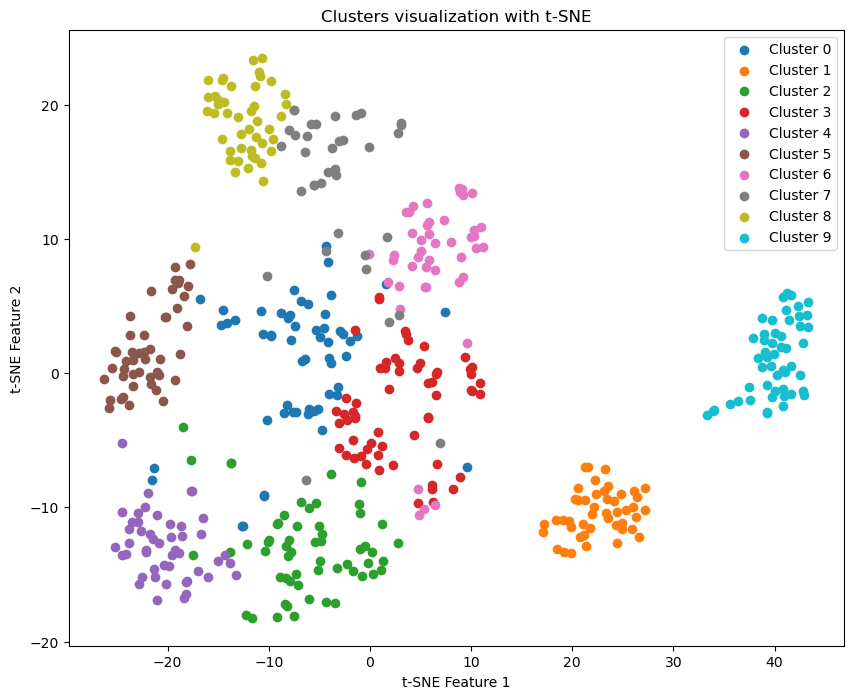

In [23]:
# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(tsne_features[clusters == i, 0], tsne_features[clusters == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Clusters visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


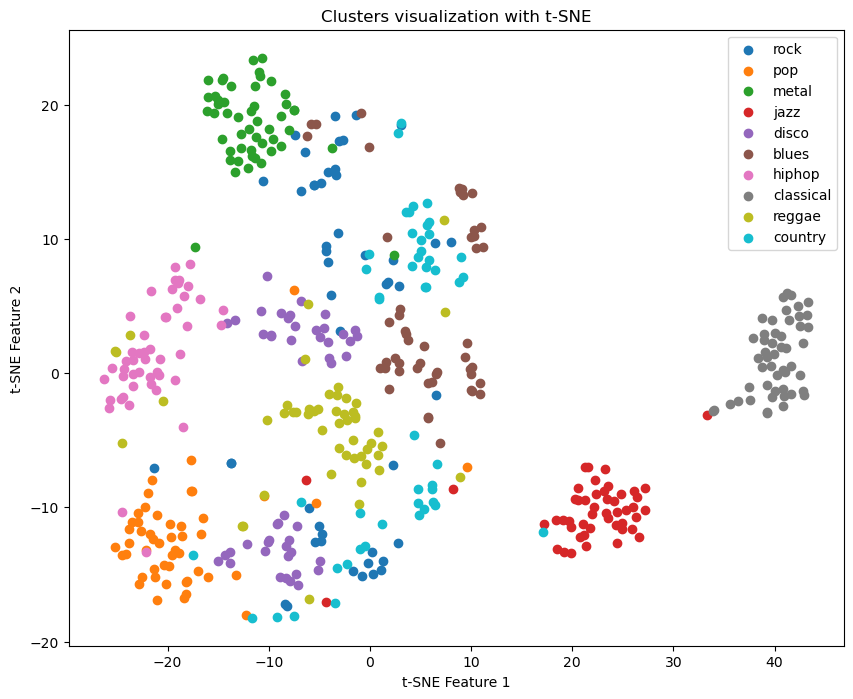

In [24]:
# Plot the clusters
plt.figure(figsize=(10, 8))
genres=set(train_genre)
for i,g in zip(range(n_clusters),genres):
    plt.scatter(tsne_features[train_genre == g, 0], tsne_features[train_genre ==g, 1], label=f'{g}')
plt.legend()
plt.title('Clusters visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


## Build an encoding model to find relevant voxels in the brain

In [ ]:
train_encode_model=True
thr=0.1    # thr=0.06
if train_encode_model:

    from sklearn.linear_model import RidgeCV

    voxel_models=[]
    voxels_scores=[]

    X=train_audio_feat.numpy()
    y=train_fmri_avg.numpy()

    pbar=tqdm.trange(train_fmri_avg.shape[-1],position=0)
    for v in pbar:
        vm=RidgeCV()
        y_v=y[:,v]
        vm.fit(X,y_v)
        score=vm.score(X, y_v)
        voxel_models.append(vm)
        voxels_scores.append(score)
        pbar.set_description(f"score {score}")
        
    voxels_scores=np.array(voxels_scores)
    plt.hist(voxels_scores)
    R2_img=masker.inverse_transform(np.array(voxels_scores))
    
    R2_img_smooth=nilearn.image.smooth_img(R2_img,1)
    R2_img_smooth=nilearn.image.threshold_img(R2_img_smooth,threshold=thr,cluster_threshold=100)
    R2_data=R2_img_smooth.get_fdata()

    R2_data_masked=masker.transform(R2_img_smooth)
    selected_indices=(R2_data_masked>0)
    print(selected_indices.sum())
    plotting.plot_stat_map(R2_img_smooth,display_mode="mosaic",colorbar=True,threshold=thr)
    
    #save mask
    binary_mask=(R2_data_masked>0)*1.
    mask=masker.inverse_transform(binary_mask.squeeze())
    nib.save(mask,"mask_CLAP_FT.nii.gz")
else:
    mask_loaded_ni = nib.load("mask_01.nii.gz")
    selected_indices=masker.transform(mask_loaded_ni)
    selected_indices = (selected_indices>0)
    if subj != "sub-001":
        print(subj)
        new_train_fmri = []
        new_test_fmri = []
        for i in tqdm.trange(train_fmri_avg.shape[0]):
            
            train_trans = masker.inverse_transform(train_fmri_avg[i])
            train_trans = nilearn.image.math_img("img1 * img2", img1=mask_loaded_ni, img2=train_trans)
            train_mask_trans = masker.transform(train_trans) 
            new_train_fmri.append(train_mask_trans)

        train_fmri_stacked = np.concatenate(new_train_fmri, axis=0)
        print(train_fmri_stacked.shape)

        for j in tqdm.trange(test_fmri_avg.shape[0]):
            
            test_trans = masker.inverse_transform(test_fmri_avg[j])
            test_trans = nilearn.image.math_img("img1 * img2", img1=mask_loaded_ni, img2=test_trans)
            test_mask_trans = masker.transform(test_trans)
            new_test_fmri.append(test_mask_trans)

        test_fmri_stacked = np.concatenate(new_test_fmri, axis=0)
        print(test_fmri_stacked.shape)

        train_fmri_avg=train_fmri_stacked
        test_fmri_avg=test_fmri_stacked


In [164]:
# nib.save(R2_img_smooth,"maskR2.nii.gz")

# Back to image with R2 scores, voxel selection

## Connect selected voxels with cluster labels, can we classify these musical genres?

In [165]:
def remove_duplicates_and_get_first_indices(arr):
    unique_elements = []
    first_indices = []

    for index, element in enumerate(arr):
        if element not in unique_elements:
            unique_elements.append(element)
            first_indices.append(index)

    return first_indices

In [166]:
X_train=train_fmri_avg[:,selected_indices.squeeze()]
X_test=test_fmri_avg[:,selected_indices.squeeze()]

y_train = kmeans.predict(train_audio_feat)
y_test = kmeans.predict(test_audio_feat)




In [167]:
X_test.shape

torch.Size([246, 833])

## Save maskbinary_mask

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(C=0.1,random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.14      0.20      0.17        10
           1       0.53      0.32      0.40        25
           2       0.40      0.58      0.47        24
           3       0.36      0.20      0.26        25
           4       0.29      0.25      0.27        32
           5       0.64      0.58      0.61        24
           6       0.62      0.86      0.72        21
           7       0.50      0.47      0.48        30
           8       0.15      0.17      0.16        24
           9       0.47      0.52      0.49        31

    accuracy                           0.42       246
   macro avg       0.41      0.41      0.40       246
weighted avg       0.42      0.42      0.41       246



## Genre classification

In [169]:
from sklearn.preprocessing import LabelEncoder
    
le=LabelEncoder()
train_genre_enc=le.fit_transform(train_genre)
test_genre_enc=le.transform(test_genre)

In [170]:
clf_genre = LogisticRegression(C=1,random_state=0).fit(X_train, train_genre_enc)
y_pred_genre = clf_genre.predict(X_test)

print(classification_report(test_genre_enc,y_pred_genre))


              precision    recall  f1-score   support

           0       0.28      0.29      0.29        24
           1       0.71      0.83      0.77        24
           2       0.37      0.29      0.33        24
           3       0.29      0.25      0.27        24
           4       0.61      0.58      0.60        24
           5       0.53      0.38      0.44        26
           6       0.32      0.40      0.36        25
           7       0.50      0.64      0.56        25
           8       0.50      0.31      0.38        26
           9       0.12      0.17      0.14        24

    accuracy                           0.41       246
   macro avg       0.42      0.41      0.41       246
weighted avg       0.42      0.41      0.41       246



## Ceiling

In [171]:
clf_ceiling = LogisticRegression(C=1,random_state=0).fit(train_audio_feat, train_genre_enc)
y_pred_ceil = clf_ceiling.predict(test_audio_feat)

print(classification_report(test_genre_enc,y_pred_ceil))

              precision    recall  f1-score   support

           0       0.69      0.92      0.79        24
           1       1.00      0.92      0.96        24
           2       0.78      0.58      0.67        24
           3       0.85      0.71      0.77        24
           4       0.91      0.83      0.87        24
           5       0.92      0.85      0.88        26
           6       0.76      1.00      0.86        25
           7       1.00      0.92      0.96        25
           8       0.92      0.85      0.88        26
           9       0.61      0.71      0.65        24

    accuracy                           0.83       246
   macro avg       0.84      0.83      0.83       246
weighted avg       0.84      0.83      0.83       246



## Contrastive Learning to retrieve actual songs

In [172]:
# from importlib import reload # python 2.7 does not require this
# import networks
# reload(networks)

# from networks import Encoder, ContrastiveModel
# import torch
# from torch import nn
# import pytorch_lightning as pl


In [173]:
# train_dataset=torch.utils.data.TensorDataset(torch.Tensor(X_train).float(), torch.Tensor(train_audio_feat).float(), torch.ones(len(X_train))) #single subject
# test_dataset=torch.utils.data.TensorDataset(torch.Tensor(X_test).float(), torch.Tensor(test_audio_feat).float(),torch.ones(len(X_test)))


In [174]:
# BS=64

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=True)


In [175]:
# brain_model = ContrastiveModel(num_input_channels= X_train.shape[-1], base_channel_size=[768], latent_dim=512,act_fn=nn.GELU, loss_type="contrastive", common_dim=X_train.shape[1])


In [176]:
# # Instantiate a PyTorch Lightning Trainer
# trainer = pl.Trainer(max_epochs=20, devices=[1])

# # Train the model
# trainer.fit(brain_model, train_dataloader, test_dataloader)

In [177]:
# plt.plot(brain_model.train_history["train_loss"], label='train')
# plt.plot(brain_model.val_history["val_loss"], label='val')

In [178]:
# plt.plot(brain_model.train_history["train_cosine"], label='train')
# plt.plot(brain_model.val_history["val_cosine"], label='val')

# plt.legend()

In [179]:
# x,y,k=next(iter(test_dataloader))

# z_pred=[]
# with torch.no_grad():

#     for x,y,k in tqdm.tqdm(test_dataloader):
#         y_hat=brain_model(x,k=k).cpu()
#         z_pred.append(y_hat)

# z_pred=torch.cat(z_pred,0)


In [180]:
# # similarity=  torch.nn.functional.softmax(.1*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred,.1).T)

# z_i=z_pred
# z_j=torch.Tensor(test_audio_feat).float()

# z_i = nn.functional.normalize(z_i, dim=1)
# z_j = nn.functional.normalize(z_j, dim=1)

# logits = (z_i @ z_j.T) / .1

# similarity =  torch.nn.functional.softmax(logits,-1)
# top_indices=torch.topk(similarity,10,1).indices
# # similarity=  torch.nn.functional.softmax(10*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred.T,-1))

In [181]:
# sns.heatmap(similarity)

In [182]:
# idx=3
# print(test_genre[idx])
# ipd.Audio(test_audio[idx],rate=test_sr[idx])

In [183]:
# print(test_genre[top_indices[idx]])
# ipd.Audio(test_audio[top_indices[idx][-1]],rate=test_sr[idx])

In [184]:
# top_indices[idx]

In [185]:
# ## quantitative
# acc=0
# for idx in range(len(X_test)):
#     if test_genre[idx] in test_genre[top_indices[idx]]:
#         acc+=1

# acc/=len(X_test)
# acc

## Nearest Neighbours

In [186]:
## train a Ridge regression between X_train and audio_features
from sklearn.linear_model import RidgeCV

brain_to_latent=RidgeCV(alphas=[0.1,1,10,1e2,1e3])
brain_to_latent.fit(X_train, train_audio_feat)

RidgeCV(alphas=[0.1, 1, 10, 100.0, 1000.0])

In [187]:
audio_feat_pred=brain_to_latent.predict(X_test)

In [188]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(test_audio_feat)

In [189]:
distances, top_indices = nbrs.kneighbors(audio_feat_pred)

In [190]:
import seaborn as sns
import IPython.display as ipd

In [191]:
idx=42
print(test_genre[idx])
ipd.Audio(test_audio[idx],rate=test_sr[idx])

hiphop


In [192]:
print(test_genre[top_indices[idx]])
ipd.Audio(test_audio[top_indices[idx][-1]],rate=test_sr[idx])       

['hiphop' 'hiphop' 'reggae' 'reggae' 'reggae' 'hiphop' 'hiphop' 'reggae'
 'disco' 'disco']


In [193]:
top_indices[idx]

array([ 72,  62, 215, 205, 245, 181,  42, 235, 121, 111])

In [194]:
## quantitative
acc=0
for idx in range(len(X_test)):
    if test_genre[idx] in test_genre[top_indices[idx]]:
        acc+=1

acc/=len(X_test)
acc

0.7357723577235772

In [195]:
from scipy.stats import pearsonr

def identification_accuracy(predicted_embeddings, target_embeddings):
    # Compute the Pearson correlation coefficient matrix
    correlation_matrix = np.zeros((len(predicted_embeddings), len(target_embeddings)))
    for i in range(len(predicted_embeddings)):
        for j in range(len(target_embeddings)):
            corr, _ = pearsonr(predicted_embeddings[i], target_embeddings[j])
            correlation_matrix[i, j] = corr
    
    # Compute the identification accuracy for each prediction
    n = len(predicted_embeddings)
    id_acc_per_example = []
    for i in range(n):
        id_acc_i = np.mean([1 if correlation_matrix[i, i] > correlation_matrix[i, j] else 0 for j in range(n)])
        id_acc_per_example.append(id_acc_i)
    
    # Compute the overall identification accuracy
    id_acc = np.mean(id_acc_per_example)
    
    return id_acc



In [196]:
accuracy = identification_accuracy(audio_feat_pred, test_audio_feat)

In [197]:
accuracy

0.8098023663163462